Three observable trends on the data:
    1. Most tweets from news sources are neutral when scored by vader
    2. 4 of the 5 news sources are positive in their compound score, though still relatively close to neutral
        a) CBS is the most positive
        b) CNN is the only negative
    3. Though most tweets are scored neutral, and the compound lean toward neutral, there are significant positive and negative tweets, leading me to believe there is a canceling-out effect happening in the model.

In [16]:
# Dependencies
import tweepy
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from twitconfig import (consumer_key, consumer_secret, access_token, access_token_secret)

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

from pprint import pprint

In [17]:
# Twitter API Keys
consumer_key = consumer_key
consumer_secret = consumer_secret
access_token = access_token
access_token_secret = access_token_secret

In [18]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [19]:
# Target Search Term
target_terms = ("@CNN", "@BBC", "@CBS",
                "@FoxNews", "@nytimes")

In [20]:
# List to hold results
results_list = []
ctr = 0

# create dataframe to hold all tweets with the columns
all_tweet_df = pd.DataFrame(columns= ['Source', 'Text', 'Date', 'Compound', 'Positive', 
                                      'Neutral', 'Negative', 'Counter'])

# Loop through all target users
for target in target_terms:

    # Variable for holding the oldest tweet
    oldest_tweet = None

    # Variables for holding sentiments
    compound_list = []
    positive_list = []
    negative_list = []
    neutral_list = []
    tweet_number = []
    tweet_text = []
    created_at = []

    # get tweets using the api_timeline to return status objects
    public_tweets = api.user_timeline(screen_name = target, count=100)

    # Loop through all tweets
    for tweet in public_tweets:
        ctr += 1

        # Run Vader Analysis on each tweet
        results = analyzer.polarity_scores(tweet["text"])
        compound = results["compound"]
        pos = results["pos"]
        neu = results["neu"]
        neg = results["neg"]

        # Add each value to the appropriate list
        compound_list.append(compound)
        positive_list.append(pos)
        negative_list.append(neg)
        neutral_list.append(neu)
        tweet_number.append(ctr)
        tweet_text.append(tweet["text"])
        created_at.append(tweet["created_at"])

        # Set the new oldest_tweet value
        oldest_tweet = tweet["id"] - 1
    
    # append Dataframe with above data 
        all_tweet_df = all_tweet_df.append({'Source':target, 'Text':tweet['text'], 'Date':tweet['created_at'], 
                                            'Compound':compound, 'Positive':pos, 'Neutral':neu, 
                                            'Negative':neg, 'Counter':ctr}, ignore_index=True)
        
    # reset ctr for next target/username
    ctr = 0
    
    # Store the Average Sentiments
    sentiment = {
        "Source": target,
        "Compound": np.mean(compound_list),
        "Positive": np.mean(positive_list),
        "Neutral": np.mean(negative_list),
        "Negative": np.mean(neutral_list),
        "Tweet Count": len(compound_list)
    }
    
    # Append airline results to 'results_list'
    results_list.append(sentiment)

In [21]:
summary_df = pd.DataFrame(results_list)
summary_df

,Compound,Negative,Neutral,Positive,Source,Tweet Count
0,-0.059745,0.86046,0.08171,0.05780,@CNN,100
1,0.108220,0.86863,0.04251,0.08885,@BBC,100
2,0.341700,0.82289,0.02378,0.15333,@CBS,100
3,0.016680,0.81685,0.08890,0.09424,@FoxNews,100
4,0.040954,0.86101,0.05775,0.08121,@nytimes,100


In [22]:
all_tweet_df.head()

,Source,Text,Date,Compound,Positive,Neutral,Negative,Counter
0,@CNN,Looking for lower Medicare drug costs? Ask you...,Sun Jun 03 18:00:10 +0000 2018,-0.2960,0.000,0.864,0.136,1
1,@CNN,Former US attorney Preet Bharara says Presiden...,Sun Jun 03 17:45:09 +0000 2018,0.4019,0.153,0.847,0.000,2
2,@CNN,Canadian official Chrystia Freeland calls Pres...,Sun Jun 03 17:30:15 +0000 2018,-0.4939,0.000,0.758,0.242,3
3,@CNN,How one month reshaped the US immigration land...,Sun Jun 03 17:15:08 +0000 2018,0.0000,0.000,1.000,0.000,4
4,@CNN,"""The Americans"" made motherhood the ultimate d...",Sun Jun 03 17:00:11 +0000 2018,-0.2500,0.000,0.833,0.167,5


In [23]:
# send all_tweet_df to csv as per the instructions
all_tweet_df.to_csv("SentimentDF.csv")

In [24]:
df = all_tweet_df.groupby(['Source'])['Compound']
df.head()

0     -0.2960
1      0.4019
2     -0.4939
3      0.0000
4     -0.2500
100    0.0000
101    0.0000
102    0.0516
103    0.4574
104    0.4404
200   -0.3903
201    0.8442
202    0.8932
203    0.4926
204    0.0000
300   -0.2960
301   -0.2960
302   -0.3818
303    0.0000
304    0.2263
400    0.4404
401    0.0000
402    0.2023
403   -0.8020
404   -0.5106
Name: Compound, dtype: float64

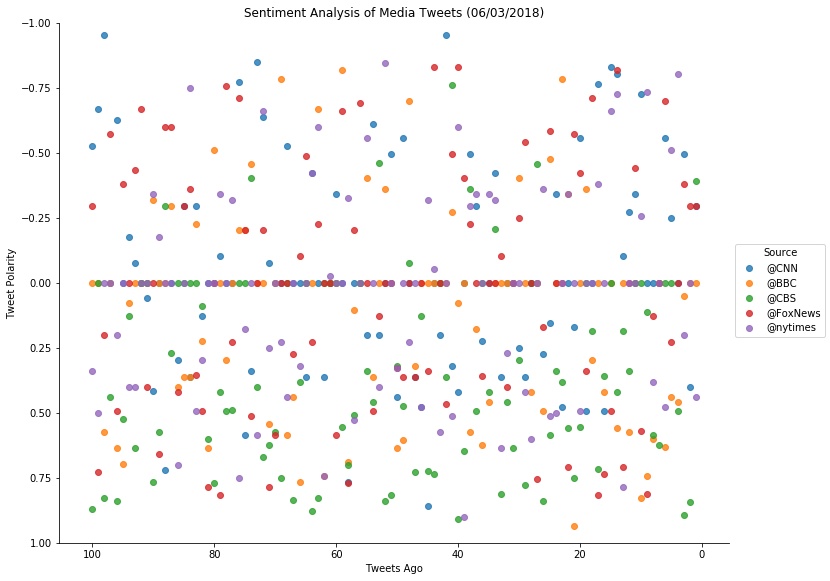

In [25]:
ax = sns.lmplot("Counter", "Compound", data=all_tweet_df, hue='Source', fit_reg=False, size=8,aspect=1.3, legend_out=True)
plt.gca().invert_xaxis()
now = datetime.now()
now = now.strftime("%m/%d/%Y")
plt.title(f"Sentiment Analysis of Media Tweets ({now})")
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Polarity")
plt.ylim(1,-1)
plt.savefig("SentAnalysisTweets.png")
plt.show()


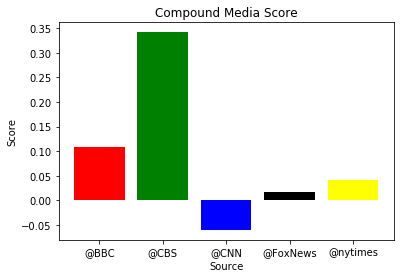

In [26]:
colors = ['blue', 'red', 'green', 'black', 'yellow']
plt.bar(summary_df['Source'], summary_df['Compound'], color=colors)
plt.title("Compound Media Score")
plt.xlabel("Source")
plt.ylabel("Score")
plt.savefig("Compound Media Score.png")
plt.show()